Installing the Libraries

In [ ]:
%pip install datasets transformers sacrebleu peft loralib rouge_score evaluate -q

Python(41460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
36216.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import get_scheduler
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import functional as F
from peft import LoraConfig, get_peft_model, TaskType

In [2]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
raw_datasets = load_dataset("cfilt/iitb-english-hindi") # Returns a DatasetDict

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})

In [ ]:
raw_datasets['train'][1]

{'translation': {'en': 'Accerciser Accessibility Explorer',
  'hi': 'एक्सेर्साइसर पहुंचनीयता अन्वेषक'}}

## Data Preprocessing

In [8]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-hi"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/Users/vishalvarma/Library/Python/3.9/lib/python/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
tokenizer(text = "Hello, this is a sentence!")

{'input_ids': [12110, 2, 90, 23, 19, 8800, 61, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer(text = ["Hello, this is a sentence!", "This is another sentence."])

{'input_ids': [[12110, 2, 90, 23, 19, 8800, 61, 0], [239, 23, 414, 8800, 3, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

In [ ]:
# Tokenize using the Decoder specific toeknization rules.
print(tokenizer(text_target = ["Hello, this is a sentence!", "एक्सेर्साइसर पहुंचनीयता अन्वेषक"]))

{'input_ids': [[2204, 10967, 818, 2, 90, 23, 19, 44, 16, 4072, 1936, 5386, 61, 0], [26618, 16155, 346, 33383, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}


#### We can see that the encoder and the decoder use the same tokenization logic.

In [ ]:
max_input_length = 128
max_target_length = 128

source_lang = 'en'
target_lang = 'hi'

def preprocess_function(examples):
  inputs = [ex[source_lang] for ex in examples["translation"]]
  targets = [ex[target_lang] for ex in examples["translation"]]
  model_inputs = tokenizer(inputs, max_length = max_input_length, truncation = True)

  # Setup the tokenization for targets
  labels = tokenizer(text_target=targets, max_length = max_target_length, truncation = True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [ ]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[3872, 85, 2501, 132, 15441, 36398, 0], [32643, 28541, 36253, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1]], 'labels': [[63, 2025, 18, 16155, 346, 20311, 24, 2279, 679, 0], [26618, 16155, 346, 33383, 0]]}

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched = True) # Applies the function 'preprocess_function' to each split (train, test, val)
tokenized_datasets = tokenized_datasets.remove_columns(raw_datasets["train"].column_names) # Removes the columns that are not needed anymore

In [10]:
def print_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

Applying LORA

In [11]:
# Selection of the model architecture, using the weights from the pretrained model
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, torch_dtype = torch.bfloat16)

print(print_model_parameters(model))

lora_config = LoraConfig(
    r = 16,
    lora_alpha = 16,
    target_modules = ["q_proj", "v_proj"],
    lora_dropout = 0.05,
    bias = "none",
    task_type = TaskType.SEQ_2_SEQ_LM,
)

peft_model = get_peft_model(model, lora_config).to(device)
print(print_model_parameters(peft_model))

trainable model parameters: 75856896
all model parameters: 76381184
percentage of trainable model parameters: 99.31%
trainable model parameters: 589824
all model parameters: 76971008
percentage of trainable model parameters: 0.77%


In [ ]:
# The Data Collator will take the data in batches rather than the whole to pass it to the model
data_collator = DataCollatorForSeq2Seq(
    tokenizer = tokenizer,
    model = peft_model,
    return_tensors = "pt"
)

In [ ]:
generation_data_collator = DataCollatorForSeq2Seq(
    tokenizer = tokenizer,
    model = peft_model,
    return_tensors = "pt",
    pad_to_multiple_of = 8
)

In [ ]:
batch_size = 8
learning_rate = 5e-5
weight_decay = 0.01

In [ ]:
train_data = DataLoader(
    tokenized_datasets['train'],
    batch_size = batch_size,
    shuffle = True,
    collate_fn = data_collator,
)

In [ ]:
validation_data = DataLoader(
    tokenized_datasets['validation'],
    batch_size = batch_size,
    shuffle = False,
    collate_fn = data_collator
)

In [ ]:
generation_data = DataLoader(
    tokenized_datasets['validation'],
    batch_size = batch_size,
    shuffle = False,
    collate_fn = generation_data_collator
)

In [ ]:
num_train_epochs = 5
num_train_steps = num_train_epochs * len(train_data)

In [ ]:
optimizer = AdamW(params = peft_model.parameters(), lr = learning_rate, weight_decay = weight_decay)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

### Model Training

In [ ]:
def evaluate(model, val_dataloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculations
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss

In [ ]:
for epoch in range(num_train_epochs):
    peft_model.train()
    total_loss = 0

    print(epoch)
    i = 0
    for batch in train_data:
        batch = {k: v.to(device) for k, v in batch.items() if k != "token_type_ids" }
        outputs = peft_model(**batch)
        loss = outputs.loss

        print(f"Batch {i}: Loss: {loss.item()}")
        i += 1

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_data)
    avg_val_loss = evaluate(peft_model, validation_data)

    print(f"Epoch {epoch+1}/{num_train_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

0
Batch 0: Loss: 3.625
Batch 1: Loss: 2.953125
Batch 2: Loss: 2.484375
Batch 3: Loss: 2.765625
Batch 4: Loss: 2.921875
Batch 5: Loss: 3.21875
Batch 6: Loss: 3.40625
Batch 7: Loss: 4.71875
Batch 8: Loss: 4.875
Batch 9: Loss: 3.296875
Batch 10: Loss: 1.8984375
Batch 11: Loss: 3.8125
Batch 12: Loss: 2.375
Batch 13: Loss: 5.09375
Batch 14: Loss: 3.234375
Batch 15: Loss: 2.3125
Batch 16: Loss: 3.015625
Batch 17: Loss: 4.84375
Batch 18: Loss: 3.140625
Batch 19: Loss: 2.375
Batch 20: Loss: 4.25
Batch 21: Loss: 2.328125
Batch 22: Loss: 4.28125
Batch 23: Loss: 4.59375
Batch 24: Loss: 3.875
Batch 25: Loss: 3.171875
Batch 26: Loss: 3.171875
Batch 27: Loss: 2.984375
Batch 28: Loss: 1.96875
Batch 29: Loss: 2.484375
Batch 30: Loss: 2.6875
Batch 31: Loss: 2.046875
Batch 32: Loss: 3.296875
Batch 33: Loss: 3.09375
Batch 34: Loss: 5.21875
Batch 35: Loss: 2.453125
Batch 36: Loss: 3.75
Batch 37: Loss: 4.34375
Batch 38: Loss: 2.921875
Batch 39: Loss: 3.4375
Batch 40: Loss: 3.5
Batch 41: Loss: 2.875
Batch 4

KeyboardInterrupt: 

### Saving the model

In [12]:
peft_model.save_pretrained("./hel_Finetune_en_hi_hel")
tokenizer.save_pretrained("./hel_Finetune_en_hi_hel")

('./hel_Finetune_en_hi_hel/tokenizer_config.json',
 './hel_Finetune_en_hi_hel/special_tokens_map.json',
 './hel_Finetune_en_hi_hel/vocab.json',
 './hel_Finetune_en_hi_hel/source.spm',
 './hel_Finetune_en_hi_hel/target.spm',
 './hel_Finetune_en_hi_hel/added_tokens.json')

## Model Testing

In [21]:
input_text = "this is hot!"

tokenized = tokenizer(
    [input_text],
    return_tensors = 'pt'
).to(device)
out = peft_model.generate(**tokenized, max_length = 128)
print(out)

tensor([[61949,    60,  6848,     5,    61,     0]], device='mps:0')


In [22]:
print(tokenizer.decode(out[0]))

<pad> यह गर्म है!</s>


calculating scores

In [23]:
from transformers import pipeline ,AutoTokenizer, AutoModelForSeq2SeqLM
import torch,sacrebleu,nltk
from rouge_score import rouge_scorer
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
from datasets import load_dataset
import random


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vishalvarma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:



test_data = raw_datasets["test"]


In [28]:
# english_sentence = "my family stays out of the Australia"
# hindi_translation = preprocess_text(english_sentence)
# print("Translated:", hindi_translation)


#sample = random.choice(test_data)
#english_text = sample["translation"]["en"]
#hindi_reference = sample["translation"]["hi"]
#translated_hindi = preprocess_text(english_text)

#print("Translated Hindi:    ", translated_hindi)
#print("English:     ", english_text)
#print("Reference Hindi:     ", hindi_reference)



In [ ]:
# Evaluation metrics function
def evaluate_translation(reference, hypothesis):
    reference_tokens = reference.split()
    hypothesis_tokens = hypothesis.split()
    
    bleu = sacrebleu.corpus_bleu([hypothesis], [[reference]]).score
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    rouge = scorer.score(reference, hypothesis)["rougeL"].fmeasure
    meteor = meteor_score([reference_tokens], hypothesis_tokens)
    
    return {"BLEU": bleu, "ROUGE": rouge, "METEOR": meteor}

# Text preprocessing function with proper device handling
def preprocess_text(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    # Move inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(**inputs)
        translated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return translated_text[0]

#  Model evaluation function
def evaluate_model(dataset, model, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else 
                         "cpu")
    
    # Move model to device once
    model = model.to(device)
    
    bleu_scores, rouge_scores, meteor_scores = [], [], []
    total_samples = len(dataset["test"])
    print(f"Using device: {device}")
    print(f"Evaluating on {total_samples} test samples...")
    
    for i in range(total_samples):
        english = dataset["test"][i]["translation"]["en"]
        reference_hindi = dataset["test"][i]["translation"]["hi"]
        predicted_hindi = preprocess_text(english, model, tokenizer, device)
        
        scores = evaluate_translation(reference_hindi, predicted_hindi)
        
        bleu_scores.append(scores["BLEU"])
        rouge_scores.append(scores["ROUGE"])
        meteor_scores.append(scores["METEOR"])
        
        if i % 100 == 0:
            print(f"Processed {i}/{total_samples} sentences...")
    
    avg_bleu = sum(bleu_scores) / total_samples
    avg_rouge = sum(rouge_scores) / total_samples
    avg_meteor = sum(meteor_scores) / total_samples
    
    return {"BLEU": avg_bleu, "ROUGE": avg_rouge, "METEOR": avg_meteor}

Using Pretrained Model

In [32]:

scores = evaluate_model(raw_datasets,model,tokenizer)
print("\nEvaluation Scores:", scores)


Using device: mps
Evaluating on 2507 test samples...
Processed 0/2507 sentences...
Processed 100/2507 sentences...
Processed 200/2507 sentences...
Processed 300/2507 sentences...
Processed 400/2507 sentences...
Processed 500/2507 sentences...
Processed 600/2507 sentences...
Processed 700/2507 sentences...
Processed 800/2507 sentences...
Processed 900/2507 sentences...
Processed 1000/2507 sentences...
Processed 1100/2507 sentences...
Processed 1200/2507 sentences...
Processed 1300/2507 sentences...
Processed 1400/2507 sentences...
Processed 1500/2507 sentences...
Processed 1600/2507 sentences...
Processed 1700/2507 sentences...
Processed 1800/2507 sentences...
Processed 1900/2507 sentences...
Processed 2000/2507 sentences...
Processed 2100/2507 sentences...
Processed 2200/2507 sentences...
Processed 2300/2507 sentences...
Processed 2400/2507 sentences...
Processed 2500/2507 sentences...

Evaluation Scores: {'BLEU': 9.778386178152335, 'ROUGE': 0.11330924427254697, 'METEOR': 0.27073785099

### Loss Curves

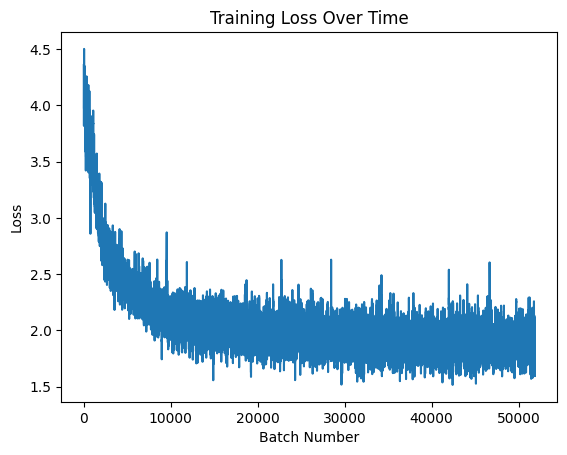

Using FineTuned Model

In [33]:
from peft import PeftModel
base_model_name = "Helsinki-NLP/opus-mt-en-hi"
adapter_path = "./hel_Finetune_en_hi_hel"  # Adjust this to your actual adapter folder name

# Load base model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)
# Load PEFT adapter
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.to(device)  # Move to Apple MPS or "cuda"/"cpu" if needed

/Users/vishalvarma/Library/Python/3.9/lib/python/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [35]:

scores = evaluate_model(raw_datasets,model,tokenizer)
print("\nEvaluation Scores:", scores)


Using device: mps
Evaluating on 2507 test samples...
Processed 0/2507 sentences...
Processed 100/2507 sentences...
Processed 200/2507 sentences...
Processed 300/2507 sentences...
Processed 400/2507 sentences...
Processed 500/2507 sentences...
Processed 600/2507 sentences...
Processed 700/2507 sentences...
Processed 800/2507 sentences...
Processed 900/2507 sentences...
Processed 1000/2507 sentences...
Processed 1100/2507 sentences...
Processed 1200/2507 sentences...
Processed 1300/2507 sentences...
Processed 1400/2507 sentences...
Processed 1500/2507 sentences...
Processed 1600/2507 sentences...
Processed 1700/2507 sentences...
Processed 1800/2507 sentences...
Processed 1900/2507 sentences...
Processed 2000/2507 sentences...
Processed 2100/2507 sentences...
Processed 2200/2507 sentences...
Processed 2300/2507 sentences...
Processed 2400/2507 sentences...
Processed 2500/2507 sentences...

Evaluation Scores: {'BLEU': 11.99987532438593, 'ROUGE': 0.13566472861446938, 'METEOR': 0.32157834036

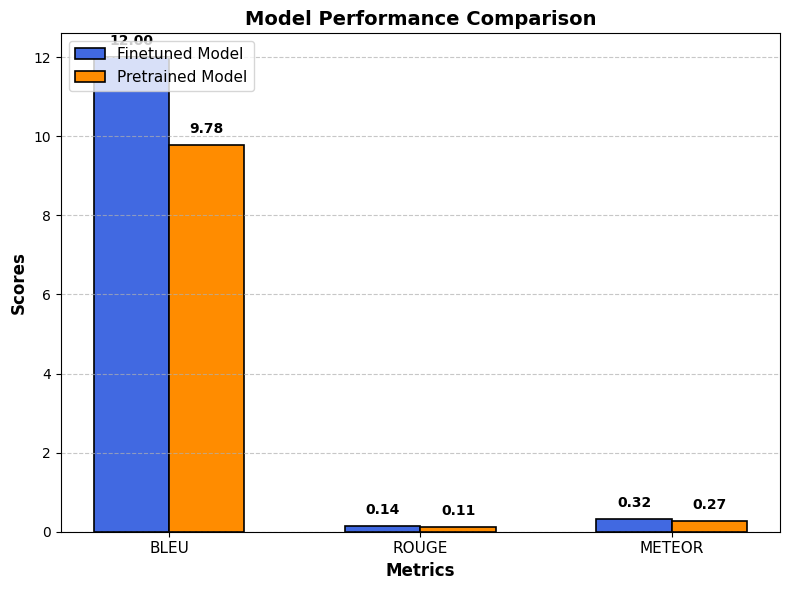

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Scores for each model
metrics = ['BLEU', 'ROUGE', 'METEOR']
finetuned_scores = [11.9999, 0.1357, 0.3216]
pretrained_scores = [9.7784, 0.1133, 0.2707]

# Bar positions
x = np.arange(len(metrics))
width = 0.3  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, finetuned_scores, width, label='Finetuned Model', color='royalblue', edgecolor='black', linewidth=1.2)
ax.bar(x + width/2, pretrained_scores, width, label='Pretrained Model', color='darkorange', edgecolor='black', linewidth=1.2)

# Labels and title
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Scores', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11, loc='upper left')

# Improve visibility with grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Annotate the bars with values
for i, v in enumerate(finetuned_scores):
    ax.text(i - width/2, v + 0.3, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold', color='black')
for i, v in enumerate(pretrained_scores):
    ax.text(i + width/2, v + 0.3, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold', color='black')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()